# Simulate second-order systems

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq.impl import impl
from probdiffeq import adaptive, ivpsolve
from probdiffeq.util.doc_util import notebook
from probdiffeq.solvers import calibrated
from probdiffeq.taylor import autodiff
from probdiffeq.solvers.strategies.components import corrections, priors
from probdiffeq.solvers.strategies import filters

In [ ]:
plt.rcParams.update(notebook.plot_style())
plt.rcParams.update(notebook.plot_sizes())

In [2]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")

Quick refresher: first-order ODEs

In [3]:
impl.select("isotropic", ode_shape=(4,))
f, u0, (t0, t1), f_args = ivps.three_body_restricted_first_order()


@jax.jit
def vf_1(y, t):
    return f(y, *f_args)


ibm = priors.ibm_adaptive(num_derivatives=4)
ts0 = corrections.ts0()
solver_1st = calibrated.mle(filters.filter_adaptive(ibm, ts0))
adaptive_solver_1st = adaptive.adaptive(solver_1st, atol=1e-5, rtol=1e-5)


tcoeffs = autodiff.taylor_mode_scan(lambda y: vf_1(y, t=t0), (u0,), num=4)
init = solver_1st.initial_condition(tcoeffs, output_scale=1.0)

In [4]:
solution = ivpsolve.solve_and_save_every_step(
    vf_1,
    init,
    t0=t0,
    t1=t1,
    dt0=0.1,
    adaptive_solver=adaptive_solver_1st,
)

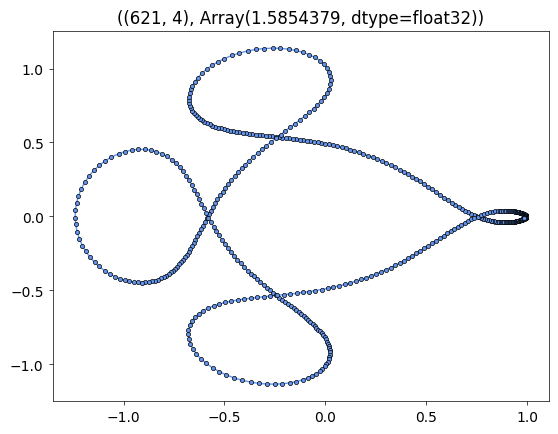

In [5]:
norm = jnp.linalg.norm((solution.u[-1, ...] - u0) / jnp.abs(1.0 + u0))
plt.title((solution.u.shape, norm))
plt.plot(solution.u[:, 0], solution.u[:, 1], marker=".")
plt.show()

The default configuration assumes that the ODE to be solved is of first order.
Now, the same game with a second-order ODE

In [6]:
impl.select("isotropic", ode_shape=(2,))
f, (u0, du0), (t0, t1), f_args = ivps.three_body_restricted()


@jax.jit
def vf_2(y, dy, t):
    return f(y, dy, *f_args)


# One derivative more than above because we don't transform to first order
ibm = priors.ibm_adaptive(num_derivatives=4)
ts0 = corrections.ts0(ode_order=2)
solver_2nd = calibrated.mle(filters.filter_adaptive(ibm, ts0))
adaptive_solver_2nd = adaptive.adaptive(solver_2nd, atol=1e-5, rtol=1e-5)


tcoeffs = autodiff.taylor_mode_scan(lambda *ys: vf_2(*ys, t=t0), (u0, du0), num=3)
init = solver_2nd.initial_condition(tcoeffs, output_scale=1.0)

/home/kraemer/Projects/probdiffeq-project/probdiffeq/probdiffeq/impl/_impl.py:103: UserWarning: An implementation has already been selected: 'isotropic'.
  warnings.warn(msg, stacklevel=1)


In [7]:
solution = ivpsolve.solve_and_save_every_step(
    vf_2,
    init,
    t0=t0,
    t1=t1,
    dt0=0.1,
    adaptive_solver=adaptive_solver_2nd,
)

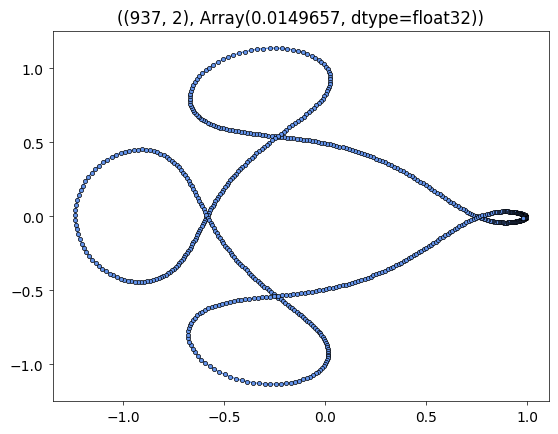

In [8]:
norm = jnp.linalg.norm((solution.u[-1, ...] - u0) / jnp.abs(1.0 + u0))
plt.title((solution.u.shape, norm))
plt.plot(solution.u[:, 0], solution.u[:, 1], marker=".")
plt.show()

The results are indistinguishable from the plot. While the runtimes of both solvers are similar, the error of the second-order solver is much lower. 

See the benchmarks for more quantitative versions of this statement.